In [252]:
setwd("/mnt/d/workdir_for_Linux/work/brainnetome/Notebook/Bioinformatics/CellCommunication/NicheNet")

library(nichenetr)
library(tidyverse)

library(ggplot2)
library(cowplot)
library(ggpubr)


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend




In [20]:
# L-R model: prior potential that a ligand might regulate the expression of target genes.
## target in rows, ligands in columns
ligand_target_matrix <- readRDS("./data/ligand_target_matrix.rds")
dim(ligand_target_matrix)

[1] 25345   688

In [40]:
# cancer-associated fibroblasts (CAF) and neighboring malignant cells
hnscc_expression <- readRDS("./data/hnscc_expression.rds")
expression <- hnscc_expression$expression  # row:cells; column: genes
sample_info <- hnscc_expression$sample_info
dim(expression)
dim(sample_info)

[1]  5902 23686

[1] 5902    7

# Question
* which ligands expressed by CAFs can induce p-EMT in neighboring malignant cells ?

# Step1: Define expressed genes in sender and reveiver cell population
* cell selection: 选择高质量的肿瘤样本
    * 去除来自 **低质量的肿瘤样本** 以及 **淋巴结转移(lymph node metastases)** 样本
* gene selection: Expression aggregation method from paper, 5000~10000
    * $Ea(gene_i) = \log_2 (Mean(TPM(gene_{i, \cdots, K})) + 1 ) >= 4$
    * 也可以有其他的筛选方式
    * 数量在5000 ~ 10000 比较合理，注意要区分低质量细胞过滤的条件(500~2000)

In [37]:
## cell selection
tumors_remove <- c("HN10","HN","HN12", "HN13", "HN24", "HN7", "HN8","HN23") #低质量肿瘤样本
CAF_ids <- sample_info %>% filter(`Lymph node` == 0 & !(tumor %in% tumors_remove) & `non-cancer cell type` == "CAF") %>% pull(cell)
malignant_ids <- sample_info %>% filter(`Lymph node` == 0 & !(tumor %in% tumors_remove) & `classified  as cancer cell` == 1) %>% pull(cell)
length(CAF_ids)
length(malignant_ids)

[1] 404

[1] 1388

In [59]:
## expressed gene selection
expressed_genes_sender <- colnames(expression)[log2(colMeans((2**expression[CAF_ids, ]-1)*10) + 1) >= 4]
expressed_genes_receiver <- colnames(expression)[log2(colMeans((2**expression[malignant_ids, ]-1)*10) + 1) >= 4]
length(expressed_genes_sender)
length(expressed_genes_receiver)

[1] 6706

[1] 6351

# Step2: Define gene set of interest and background
* interest gene set: 这个基因集的确认与要研究的问题有关，在这个例子中使用的是p-EMT相关的基因
* background gene set: 一般使用receiver cell中所有expressed gene

In [68]:
## intereset gene set
geneset_oi <- read.table("./data/pemt_signature.txt")$V1
# 由于数据中可能没有使用official HGNC symbol，所以名称上可能跟prior model存在差异
geneset_oi <- geneset_oi[geneset_oi %in% rownames(ligand_target_matrix)] 
length(geneset_oi)
head(geneset_oi)

[1] 96

[1] "SERPINE1" "TGFBI"    "MMP10"    "LAMC2"    "P4HA2"    "PDPN"

In [70]:
## background gene set
background_expressed_genes <- expressed_genes_receiver[expressed_genes_receiver %in% rownames(ligand_target_matrix) ]
length(background_expressed_genes)
head(background_expressed_genes)

[1] 6072

[1] "RPS11"   "ELMO2"   "PNMA1"   "MMP2"    "TMEM216" "ERCC5"

# Step3: Define a set of potential ligands
* expressed by sender cells
* bind putative receptor expressed by receicer cells

In [173]:
lr_network <- readRDS("./data/lr_network.rds")
head(lr_network)

from,to,source,database
<chr>,<chr>,<chr>,<chr>
CXCL1,CXCR2,kegg_cytokines,kegg
CXCL2,CXCR2,kegg_cytokines,kegg
CXCL3,CXCR2,kegg_cytokines,kegg
CXCL5,CXCR2,kegg_cytokines,kegg
PPBP,CXCR2,kegg_cytokines,kegg
CXCL6,CXCR2,kegg_cytokines,kegg


In [113]:
expressed_ligands <- intersect(unique(lr_network$from), expressed_genes_sender)
expressed_receptors <- intersect(unique(lr_network$to), expressed_genes_receiver)
lr_network_expressed <- filter(lr_network, from %in% expressed_ligands & to %in% expressed_receptors)
potential_ligands <- unique(lr_network_expressed$from)

length(potential_ligands)
head(potential_ligands)

[1] 131

[1] "HGF"     "TNFSF10" "TGFB2"   "TGFB3"   "INHBA"   "CD99"

# Step4: Ligand activity analysis on gene set of interest
* ligand activity表征的是 **特定配体** 对 **感兴趣基因集** 的调控活性

In [142]:
ligand_activities <- predict_ligand_activities(geneset = geneset_oi,
                                               background_expressed_genes = background_expressed_genes,
                                               ligand_target_matrix = ligand_target_matrix,
                                               potential_ligands = potential_ligands)
best_upstream_ligands <- arrange(ligand_activities, -pearson)[1:20,]$test_ligand
head(best_upstream_ligand)

[1] "PTHLH"  "CXCL12" "AGT"    "TGFB3"  "IL6"    "INHBA"

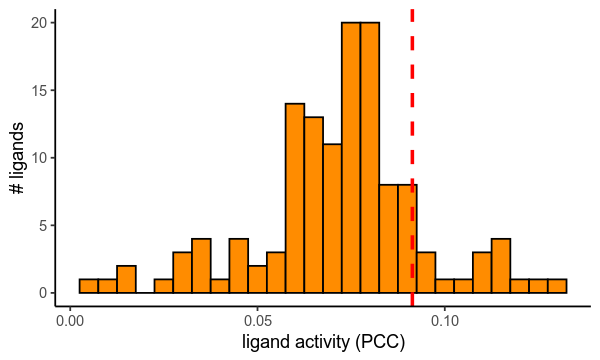

In [132]:
options(repr.plot.width=5, repr.plot.height=3)
ggplot(ligand_activities, aes(x=pearson)) + 
  geom_histogram(color="black", fill="darkorange", binwidth=0.005)  + 
  geom_vline(aes(xintercept=min(ligand_activities %>% top_n(20, pearson) %>% pull(pearson))), color="red", linetype="dashed", size=1) + 
  labs(x="ligand activity (PCC)", y = "# ligands") +
  theme_classic()

# Step5: infer target genes of top-ranked ligands
* 根据`ligand_target_matrix`矩阵，选取每个`best_upstream_ligand`中排名前250的，并与感兴趣的基因集取交集，获取ligand对target的regulatory score
* 为了可视化的需要，需要进一步优化：
    * 整体`regulatory score`小于25%分位数的置为0
    * target或ligand对应的行列都为0的，舍去
    * 根据`ligand和target的相关矩阵`进行聚类并排序
    * 输出最终的`regulatory score matrix`

In [152]:
active_ligand_target_links_df = best_upstream_ligands %>% lapply(get_weighted_ligand_target_links,geneset = geneset_oi, ligand_target_matrix = ligand_target_matrix, n = 250) %>% bind_rows()
nrow(active_ligand_target_links_df)
head(active_ligand_target_links_df)

[1] 143

ligand,target,weight
<chr>,<chr>,<dbl>
PTHLH,COL1A1,0.003992303
PTHLH,MMP1,0.004247691
PTHLH,MMP2,0.002096993
PTHLH,MYH9,0.001161564
PTHLH,P4HA2,0.001904170
PTHLH,PLAU,0.004010229


In [153]:
# for visualisation purpose
active_ligand_target_links = prepare_ligand_target_visualization(ligand_target_df = active_ligand_target_links_df, 
                                                                 ligand_target_matrix = ligand_target_matrix, 
                                                                 cutoff = 0.25)
nrow(active_ligand_target_links)
head(active_ligand_target_links)

[1] 31

,CXCL9,CXCL11,VCAM1,CTGF,MMP9,COL4A1,BMP5,TGFB3,INHBA,PTHLH,IL24,FN1,CXCL12,IL6,AGT,TNC,PSEN1,ADAM17,CXCL2
COL4A2,0.000000000,0.000000000,0.000000000,0.001182925,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0,0.000000000,0.000000000,0.004558775,0.000000000,0,0.000000000,0.000000000
INHBA,0.000000000,0.000000000,0.000000000,0.001035488,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0,0.000000000,0.000000000,0.004807617,0.000000000,0,0.000000000,0.000000000
MMP2,0.001798655,0.001817086,0.001741323,0.005361267,0.004187847,0.000000000,0.000000000,0.000000000,0.000000000,0.002096993,0.001446719,0,0.002009248,0.002334260,0.005067654,0.002094765,0,0.000000000,0.000000000
TIMP3,0.000000000,0.000000000,0.000000000,0.001215270,0.000000000,0.000000000,0.001072429,0.000000000,0.000000000,0.000000000,0.001939212,0,0.000000000,0.002665667,0.004516368,0.002224406,0,0.004734140,0.002156749
COL1A1,0.000000000,0.000000000,0.000000000,0.001475520,0.001111110,0.000000000,0.001308809,0.001235857,0.001233460,0.003992303,0.001563093,0,0.000000000,0.004251211,0.003961707,0.000000000,0,0.001110954,0.000000000
PLAU,0.000000000,0.000000000,0.000000000,0.001727393,0.001216580,0.001126469,0.001408460,0.001289604,0.001338574,0.004010229,0.001900694,0,0.000000000,0.001572387,0.003981353,0.000000000,0,0.002521586,0.001049923


Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



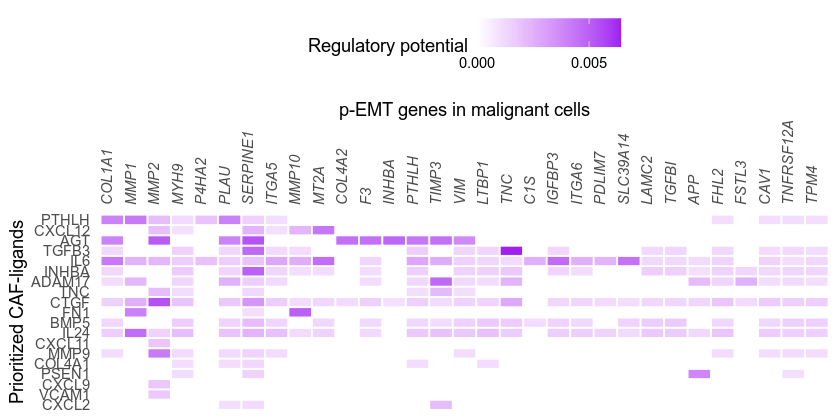

In [255]:
order_ligands = intersect(best_upstream_ligands, colnames(active_ligand_target_links)) %>% rev()
order_targets = active_ligand_target_links_df$target %>% unique()
vis_ligand_target = active_ligand_target_links[order_targets, order_ligands] %>% t()

options(repr.plot.width=7, repr.plot.height=3.5)
p_ligand_target_network = vis_ligand_target %>% make_heatmap_ggplot("Prioritized CAF-ligands","p-EMT genes in malignant cells", color = "purple",legend_position = "top", x_axis_position = "top",legend_title = "Regulatory potential") + scale_fill_gradient2(low = "whitesmoke",  high = "purple", breaks = c(0,0.005,0.01)) + theme(axis.text.x = element_text(face = "italic"))
p_ligand_target_network

# Follow up analysis1: L-R network inference

In [184]:
lr_network_top <- filter(lr_network, from %in% best_upstream_ligands & to %in% expressed_receptors)[, c("from", "to")]
best_upstream_receptor <- unique(lr_network_top$to)

In [177]:
weighted_networks = readRDS("./data/weighted_networks.rds")

In [195]:
lr_network_top_df <- filter(weighted_networks$lr_sig, from %in% best_upstream_ligands & to %in% best_upstream_receptor)
lr_network_top_df <- spread(lr_network_top_df, "from", "weight", fill=0) # 长转宽
lr_network_top_matrix <- as.matrix(data.frame(lr_network_top_df, row.names=1))

In [196]:
dist_receptors = dist(lr_network_top_matrix, method = "binary")
hclust_receptors = hclust(dist_receptors, method = "ward.D2")
order_receptors = hclust_receptors$labels[hclust_receptors$order]

dist_ligands = dist(lr_network_top_matrix %>% t(), method = "binary")
hclust_ligands = hclust(dist_ligands, method = "ward.D2")
order_ligands_receptor = hclust_ligands$labels[hclust_ligands$order]

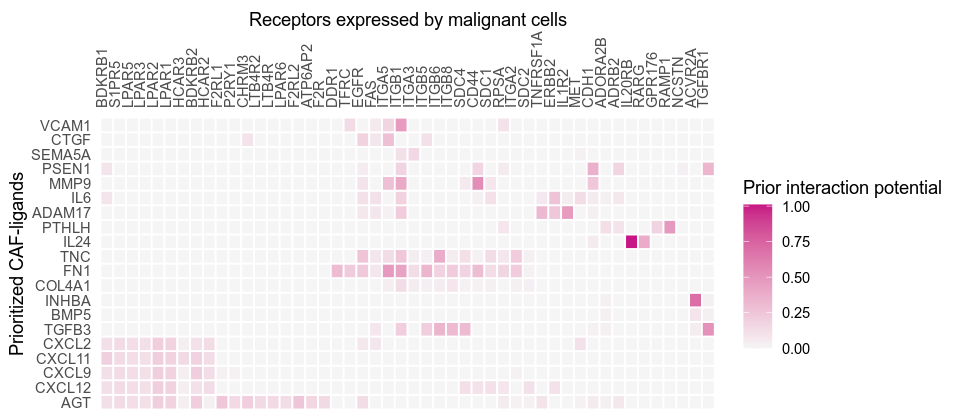

In [200]:
options(repr.plot.width=8, repr.plot.height=3.5)
vis_ligand_receptor_network = lr_network_top_matrix[order_receptors, order_ligands_receptor]
p_ligand_receptor_network = vis_ligand_receptor_network %>% t() %>% make_heatmap_ggplot("Prioritized CAF-ligands","Receptors expressed by malignant cells", 
                                                                                        color = "mediumvioletred", x_axis_position = "top", 
                                                                                        legend_title = "Prior interaction potential", legend_position = "right")
p_ligand_receptor_network

# Follow up analysis2: Visualize expression of ligands and their target genes

In [236]:
ligand_pearson_matrix = ligand_activities %>% select(pearson) %>% as.matrix() %>% magrittr::set_rownames(ligand_activities$test_ligand)
vis_ligand_pearson = ligand_pearson_matrix[order_ligands, ] %>% as.matrix(ncol = 1) %>% magrittr::set_colnames("Pearson")

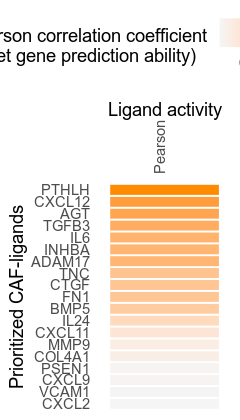

In [240]:
options(repr.plot.width=2, repr.plot.height=3.5)
p_ligand_pearson = vis_ligand_pearson %>% make_heatmap_ggplot("Prioritized CAF-ligands","Ligand activity", color = "darkorange",legend_position = "top", x_axis_position = "top", legend_title = "Pearson correlation coefficient\ntarget gene prediction ability)")
p_ligand_pearson

In [241]:
expression_df_CAF = expression[CAF_ids,order_ligands] %>% data.frame() %>% rownames_to_column("cell") %>% as_tibble() %>% inner_join(sample_info %>% select(cell,tumor), by =  "cell")
aggregated_expression_CAF = expression_df_CAF %>% group_by(tumor) %>% select(-cell) %>% summarise_all(mean)
aggregated_expression_df_CAF = aggregated_expression_CAF %>% select(-tumor) %>% t() %>% magrittr::set_colnames(aggregated_expression_CAF$tumor) %>% data.frame() %>% rownames_to_column("ligand") %>% as_tibble() 
aggregated_expression_matrix_CAF = aggregated_expression_df_CAF %>% select(-ligand) %>% as.matrix() %>% magrittr::set_rownames(aggregated_expression_df_CAF$ligand)

## this order was determined based on the paper from Puram et al. 
##Tumors are ordered according to p-EMT score.
order_tumors = c("HN6","HN20","HN26","HN28","HN22","HN25","HN5","HN18","HN17","HN16") 
vis_ligand_tumor_expression = aggregated_expression_matrix_CAF[order_ligands,order_tumors]

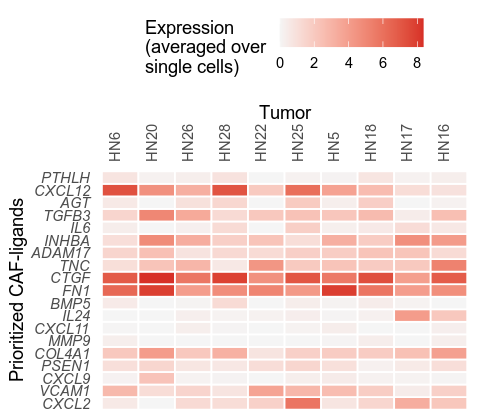

In [246]:
library(RColorBrewer)
color = colorRampPalette(rev(brewer.pal(n = 7, name ="RdYlBu")))(100)
options(repr.plot.width=4, repr.plot.height=3.5)
p_ligand_tumor_expression = vis_ligand_tumor_expression %>% make_heatmap_ggplot("Prioritized CAF-ligands","Tumor", color = color[100],legend_position = "top", x_axis_position = "top", legend_title = "Expression\n(averaged over\nsingle cells)") + theme(axis.text.y = element_text(face = "italic"))
p_ligand_tumor_expression

In [247]:
expression_df_target = expression[malignant_ids,geneset_oi] %>% data.frame() %>% rownames_to_column("cell") %>% as_tibble() %>% inner_join(sample_info %>% select(cell,tumor), by =  "cell") 
aggregated_expression_target = expression_df_target %>% group_by(tumor) %>% select(-cell) %>% summarise_all(mean)
aggregated_expression_df_target = aggregated_expression_target %>% select(-tumor) %>% t() %>% magrittr::set_colnames(aggregated_expression_target$tumor) %>% data.frame() %>% rownames_to_column("target") %>% as_tibble() 
aggregated_expression_matrix_target = aggregated_expression_df_target %>% select(-target) %>% as.matrix() %>% magrittr::set_rownames(aggregated_expression_df_target$target)
vis_target_tumor_expression_scaled = aggregated_expression_matrix_target %>% t() %>% scale_quantile() %>% .[order_tumors,order_targets]

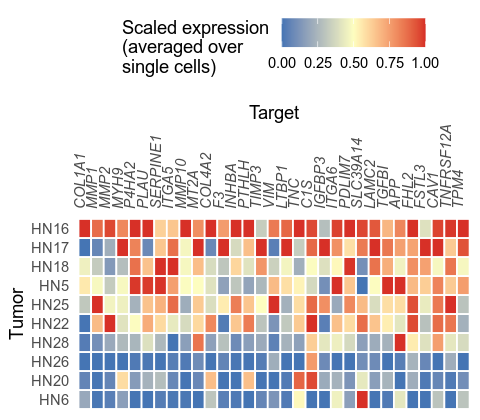

In [248]:
p_target_tumor_scaled_expression = vis_target_tumor_expression_scaled  %>% make_threecolor_heatmap_ggplot("Tumor","Target", low_color = color[1],mid_color = color[50], mid = 0.5, high_color = color[100], legend_position = "top", x_axis_position = "top" , legend_title = "Scaled expression\n(averaged over\nsingle cells)") + theme(axis.text.x = element_text(face = "italic"))
p_target_tumor_scaled_expression

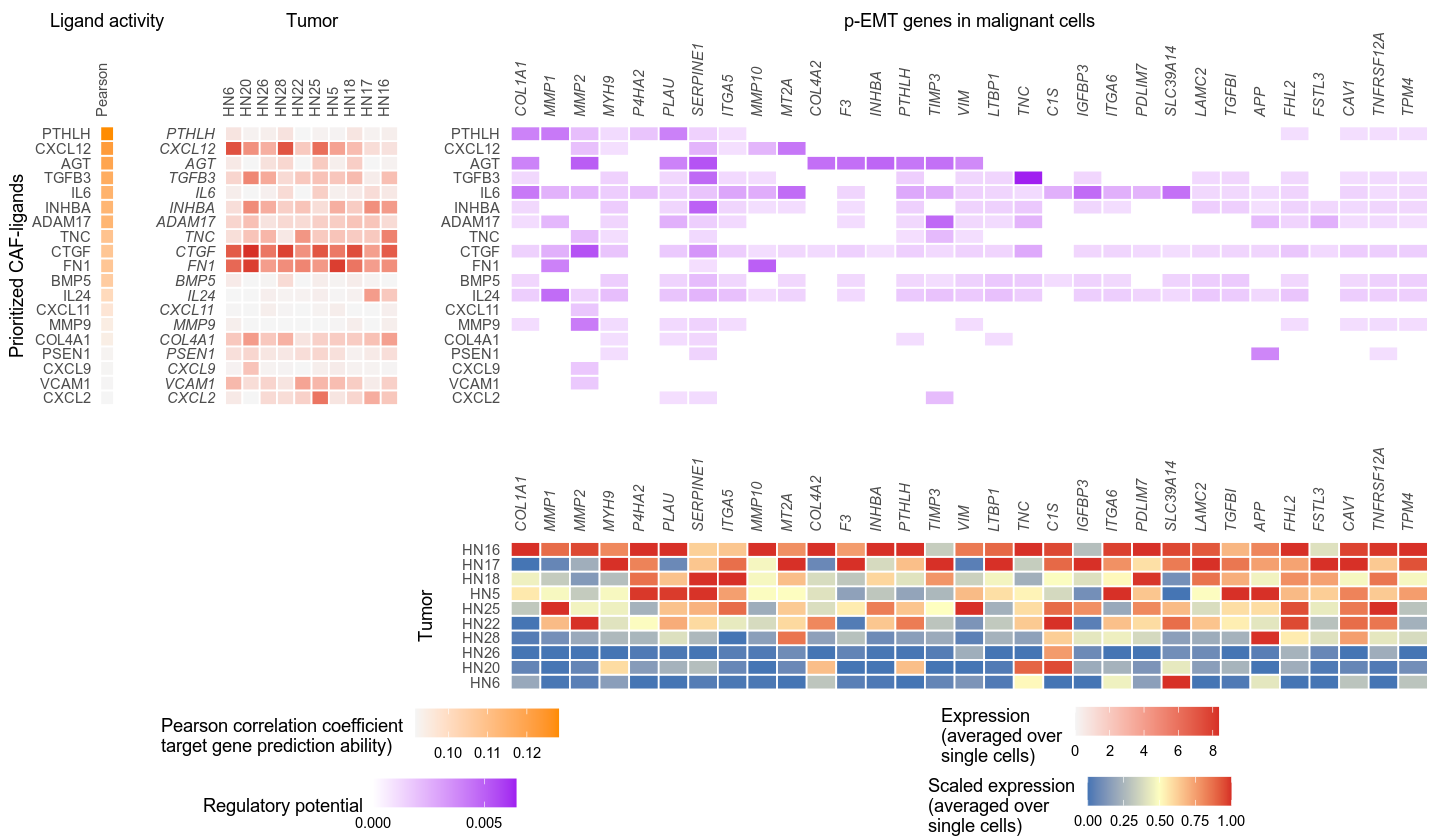

In [258]:
options(repr.plot.width=12, repr.plot.height=7)
figures_without_legend = plot_grid(
  p_ligand_pearson + theme(legend.position = "none", axis.ticks = element_blank()) + theme(axis.title.x = element_text()),
  p_ligand_tumor_expression + theme(legend.position = "none", axis.ticks = element_blank()) + theme(axis.title.x = element_text()) + ylab(""),
  p_ligand_target_network + theme(legend.position = "none", axis.ticks = element_blank()) + ylab(""), 
  NULL,
  NULL,
  p_target_tumor_scaled_expression + theme(legend.position = "none", axis.ticks = element_blank()) + xlab(""), 
  align = "hv",
  nrow = 2,
  rel_widths = c(ncol(vis_ligand_pearson)+ 4.5, ncol(vis_ligand_tumor_expression), ncol(vis_ligand_target)) -2,
  rel_heights = c(nrow(vis_ligand_pearson), nrow(vis_target_tumor_expression_scaled) + 3)) 

legends = plot_grid(
  as_ggplot(get_legend(p_ligand_pearson)),
  as_ggplot(get_legend(p_ligand_tumor_expression)),
  as_ggplot(get_legend(p_ligand_target_network)),
  as_ggplot(get_legend(p_target_tumor_scaled_expression)),
  nrow = 2,
  align = "h")

plot_grid(figures_without_legend, 
          legends, 
          rel_heights = c(10,2), nrow = 2, align = "hv")